# Demo report


In [32]:
# include libraries
import cv2
import numpy as np
import logging
import matplotlib.pyplot as plt

# define constants
AVERAGE_COUNT = 4
JUMP_THRESHOLD = 0.97  # 97% of the target value
CURSOR_TO_MV_FACTOR = 0.07
MAX_CURSOR_VALUE = 11000
MAX_SATURATION_MV_VALUE = 770
LOCAL_FILE_NAME_BMP = "snapshot.bmp"
ROI_COORDINATES_Y1 = 93
ROI_COORDINATES_Y2 = 775
ROI_COORDINATES_X1 = 755
ROI_COORDINATES_X2 = 1745
LOCAL_FILE_PATH = "E:/M15/Leader LV5600 PoC/LV5600-Automation/logs"
FLATNESS_CHECK_THRESHOLD = 20.0



### Step 1: Original Image

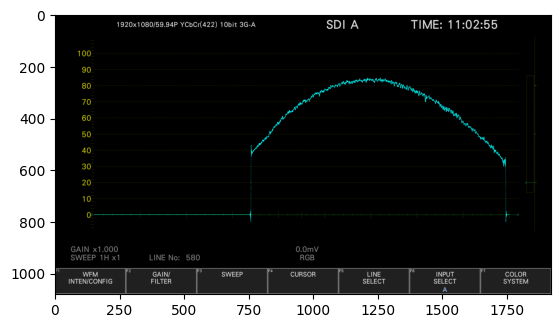

In [33]:
# load the sample image
image = cv2.imread("sample_image.bmp")

# convert color space
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# display the image
plt.imshow(image)

### Step 2: Crop to the region of interest

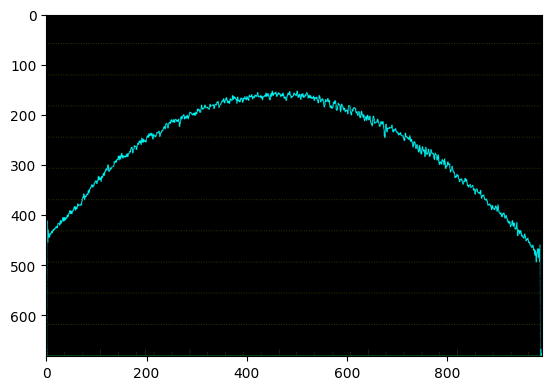

In [34]:
# crop to roi region
image = image[ROI_COORDINATES_Y1:ROI_COORDINATES_Y2, ROI_COORDINATES_X1:ROI_COORDINATES_X2]

# display image
plt.imshow(image)

### Step 3: Extract the cyan pixels

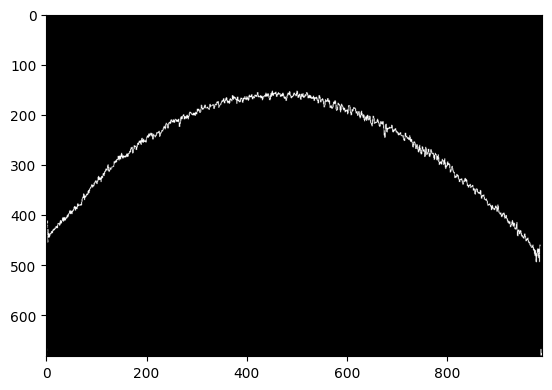

In [35]:
lower_cyan_range = np.array([0, 200, 200])
upper_cyan_range = np.array([100, 255, 255])

cyan_mask = cv2.inRange(image, lower_cyan_range, upper_cyan_range)
cyan_coordinates = np.where(cyan_mask == 255)
cyan_coordinates = np.array(cyan_coordinates)

# display the cyan mask
plt.imshow(cyan_mask, cmap="gray")
plt.show()

### Step 4: Get the mid cyan pixels


In [36]:
mid_point_x = int(image.shape[1] / 2)
mid_cyan_pixels = np.where((cyan_coordinates[1] >= mid_point_x - 5) & (cyan_coordinates[1] < mid_point_x + 5))[0]

# mean of the y coordinates of the cyan pixels in the middle of the image
mid_cyan_y = np.nanmean(cyan_coordinates[0][mid_cyan_pixels]) 

print(f"mid_cyan_y: {mid_cyan_y}")

mid_cyan_y: 161.09302325581396


* This value represents the location of the averaged y coordinates of the middle pixels of the waveform, from top to bottom
* we can use this value to calculate the cooresponding cursor level and mV value since we cropped the roi region speficically against the waveform

### Step 5: Get cursor and mV
* input: cyan_y
* output: cursor, mV


In [37]:
cyan_y = mid_cyan_y 
cursor_level = (
            1
            - cyan_y
            / float(
                ROI_COORDINATES_Y2
                - ROI_COORDINATES_Y1
            )
        ) * MAX_CURSOR_VALUE

current_mv = round(cursor_level *CURSOR_TO_MV_FACTOR, 1)
cursor_level = round(cursor_level, 0)

print(f"cursor_level: {cursor_level}")
print(f"current_mv: {current_mv}")


cursor_level: 8402.0
current_mv: 588.1


### Step 6: Flatness check
* we also need to check the flatness of the waveform, reason is that maximum mV level is 770.0 mV, hence all image that are oversaturated will be recognized as just saturated if we only check the mV level


In [38]:
def flatness_check(image, num):
        try:
            if image is None:
                raise ValueError("Image is None")

            lower_cyan_range = np.array([0, 200, 200])
            upper_cyan_range = np.array([100, 255, 255])

            cyan_mask = cv2.inRange(image, lower_cyan_range, upper_cyan_range)
            cyan_coordinates = np.where(cyan_mask == 255)
            cyan_coordinates = np.array(cyan_coordinates)

            mid_point_x = int(image.shape[1] / 2)
            # Select the middle 50 pixels around the mid_point_x
            mid_cyan_pixels = np.where((cyan_coordinates[1] >= mid_point_x - num//2) & (cyan_coordinates[1] < mid_point_x + num//2))[0]

            # Get the y-values of these pixels
            mid_cyan_y_values = cyan_coordinates[0][mid_cyan_pixels]

            # Check if all the y-values are the same (i.e., the pixels are flat)
            if np.all(mid_cyan_y_values == mid_cyan_y_values[0]):
                logging.debug(f"Image is flat")
                return True
            else:
                logging.debug(f"Image is not flat")
                return False

        except ValueError as ve:
            logging.error(f"ValueError: {ve}")
            return False

        except Exception as e:
            logging.error(f"Exception: {e}")
            return False

Flatness: False


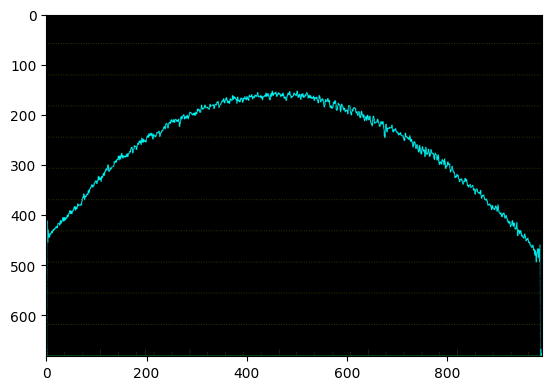

In [39]:
# let's try on our previous sample image
num_pixels = 20
res = flatness_check(image, num_pixels)

print(f"Flatness: {res}")

# display image
plt.imshow(image)

Flatness: True


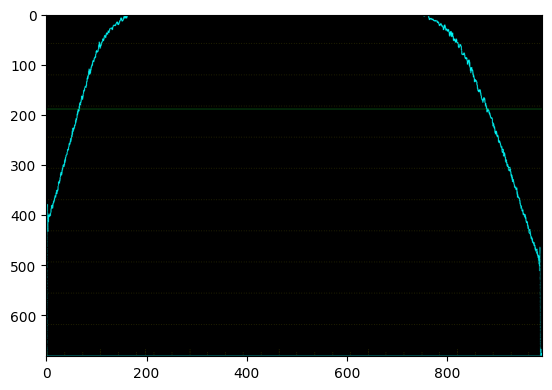

In [40]:
# let's use an oversaturated image to demonstrate

# user can define how many pixels to use for the calculation
num_pixels = 20
image = cv2.imread("oversaturated.bmp")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = image[ROI_COORDINATES_Y1:ROI_COORDINATES_Y2, ROI_COORDINATES_X1:ROI_COORDINATES_X2]


res = flatness_check(image,num_pixels)

print(f"Flatness: {res}")
# display image
plt.imshow(image)


### Finally, we send our calculated cursor value via telnet to the LV5600 for display


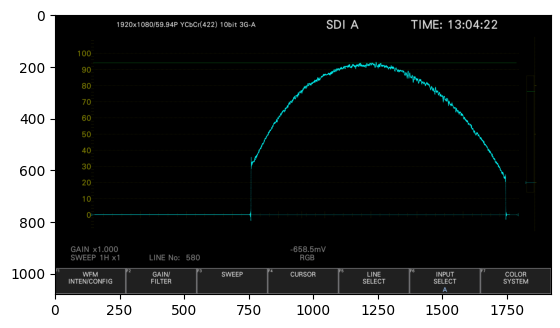

In [41]:
sample_image_with_cursor_on = cv2.imread("sample_image_with_cursor.bmp")
sample_image_with_cursor_on = cv2.cvtColor(sample_image_with_cursor_on, cv2.COLOR_BGR2RGB)
# display the image
plt.imshow(sample_image_with_cursor_on)
plt.show()

### Overview of the functions



In [42]:
class CalculationTasks:
    @staticmethod
    def calculate_middle_cyan_y(image, calculation_type) -> float:
        try:
            if image is None:
                raise ValueError("Image is None")
            if calculation_type not in ["min", "mean"]:
                raise ValueError(f"Invalid calculation type: {calculation_type}")

            lower_cyan_range = np.array([0, 200, 200])
            upper_cyan_range = np.array([100, 255, 255])

            cyan_mask = cv2.inRange(image, lower_cyan_range, upper_cyan_range)
            cyan_coordinates = np.where(cyan_mask == 255)
            cyan_coordinates = np.array(cyan_coordinates)

            mid_point_x = int(image.shape[1] / 2)
            #mid_cyan_pixels = np.where(cyan_coordinates[1] == mid_point_x)[0]
            mid_cyan_pixels = np.where((cyan_coordinates[1] >= mid_point_x - 5) & (cyan_coordinates[1] < mid_point_x + 5))[0]

            if calculation_type == "min":
                mid_cyan_y = np.nanmin(cyan_coordinates[0][mid_cyan_pixels])
            elif calculation_type == "mean":
                mid_cyan_y = np.nanmean(cyan_coordinates[0][mid_cyan_pixels])
            else:
                raise ValueError(f"Invalid calculation type: {calculation_type}")

            logging.debug(f"mid_cyan_y: {mid_cyan_y}")
            return mid_cyan_y

        except ValueError as ve:
            logging.error(f"ValueError: {ve}")
            return np.nan

        except Exception as e:
            logging.error(f"Exception: {e}")
            return np.nan

    @staticmethod
    def classify_mv_level(mv_value, target,tolerance) -> str:
        try:
            if mv_value is None:
                raise ValueError("mv_value is None")
            if target is None:
                raise ValueError("target is None")
            if not isinstance(mv_value, (int, float)):
                raise TypeError("mv_value must be a number")
            if not isinstance(target, (int, float)):
                raise TypeError("target must be a number")
            if target <= 0:
                raise ValueError("target must be greater than 0")


            #target_high = min(target * (1 + tolerance),CalculationConstants.MAX_SATURATION_MV_VALUE)
            target_high = target * (1 + tolerance)
            logging.debug(f"target_high: {target_high}")
            target_low = max(target * (1 - tolerance),0)
            logging.debug(f"target_low: {target_low}")

            if mv_value >= target_high:
                return "high"
            elif mv_value <= target_low:
                return "low"
            else:
                return "pass"

        except ValueError as ve:
            logging.error(f"ValueError: {ve}")
            return "error"

        except TypeError as te:
            logging.error(f"TypeError: {te}")
            return "error"

        except Exception as e:
            logging.error(f"Exception: {e}")
            return "error"

    @staticmethod
    async def preprocess_and_get_mid_cyan(mode):
        # get local file path from config file
        
        local_file_path = LOCAL_FILE_PATH

        image = cv2.imread(local_file_path)
        if image is None:
            raise Exception("Error reading image")

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = image[
            ROI_COORDINATES_Y1 :ROI_COORDINATES_Y2,
            ROI_COORDINATES_X1 : ROI_COORDINATES_X2,
        ]

        if mode == "SAT":
            mode = "min"
        elif mode == "WB" or mode == "NOISE":
            mode = "mean"
        else:
            raise ValueError("Invalid mode: " + str(mode))
        mid_cyan_y = CalculationTasks.calculate_middle_cyan_y(image, mode)
        flatness = CalculationTasks.flatness_check(image, FLATNESS_CHECK_THRESHOLD)

        return mid_cyan_y,flatness

    @staticmethod
    def get_cursor_and_mv(cyan_y):
        cursor_level = (
            1
            - cyan_y
            / float(
               ROI_COORDINATES_Y2
                - ROI_COORDINATES_Y1
            )
        ) * MAX_CURSOR_VALUE

        current_mv = round(cursor_level * CURSOR_TO_MV_FACTOR, 1)
        cursor_level = round(cursor_level, 0)

        logging.debug(f"cursor_level: {cursor_level}")
        logging.debug(f"current_mv: {current_mv}")
        return cursor_level, current_mv

    @staticmethod
    def flatness_check(image, num):
        try:
            if image is None:
                raise ValueError("Image is None")

            lower_cyan_range = np.array([0, 200, 200])
            upper_cyan_range = np.array([100, 255, 255])

            cyan_mask = cv2.inRange(image, lower_cyan_range, upper_cyan_range)
            cyan_coordinates = np.where(cyan_mask == 255)
            cyan_coordinates = np.array(cyan_coordinates)

            mid_point_x = int(image.shape[1] / 2)
            # Select the middle 50 pixels around the mid_point_x
            mid_cyan_pixels = np.where((cyan_coordinates[1] >= mid_point_x - num//2) & (cyan_coordinates[1] < mid_point_x + num//2))[0]

            # Get the y-values of these pixels
            mid_cyan_y_values = cyan_coordinates[0][mid_cyan_pixels]

            # Check if all the y-values are the same (i.e., the pixels are flat)
            if np.all(mid_cyan_y_values == mid_cyan_y_values[0]):
                logging.debug(f"Image is flat")
                return True
            else:
                logging.debug(f"Image is not flat")
                return False

        except ValueError as ve:
            logging.error(f"ValueError: {ve}")
            return False

        except Exception as e:
            logging.error(f"Exception: {e}")
            return False
        